In [3]:
# Uncomment when importing from GitHub
# !git clone https://www.github.com/simoneroncallo/quantum-optical-network.git
# %cd /content/quantum-optical-network
# !mkdir ./output/data

# Uncomment when importing from Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/quantum-optical-network

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/quantum-optical-network


In [4]:
import numpy as np
import pandas as pd
import collections
from typing import Callable
from scipy.special import softmax
from keras import layers, models, activations, optimizers, initializers
from keras import utils, datasets, constraints
import matplotlib.pyplot as plt
import tensorflow as tf
from dataprocessing import rgb2gray, dataset_preparation

# Parameters

In [5]:
# Set the seeds
np.random.seed(2024)
utils.set_random_seed(2024)
skseed = 2024

In [6]:
# Hyperparameters
dataset = 'mnist' # Choose {"mnist", "fashion", "cifar"}

numTrainImgs = None # Load the full dataset with "None"
numShots = -1 # Deactivate noise with "-1" - Not implented
adam = False # Activate ADAM # Default: True
constrained = True # Activate L1 and L2 constraints on the classical model

numPixels = 1024
batchSize = 1000
numEpochs = 1000 # Examples {200, 150}
learningRate = 0.03
numHiddenNeurons = 2 # Examples {2,16,64,128,256}

In [7]:
# Prepare the dataset
trainImgs, trainLabels, testImgs, testLabels = \
dataset_preparation(dataset,numTrainImgs)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set has shape (12665, 1024)
Test set has shape (2115, 1024) 



# <font color='ORANGE'>Training</font>

In [9]:
class L1Constraint(constraints.Constraint):
  """ Positivity and L1 normalization. """
  def __call__(self, w):
    w = tf.nn.relu(w)  # Apply ReLU clipping
    L1norm = tf.math.reduce_sum(w, axis=0)
    return w#/(L1norm)

class L2Constraint(constraints.Constraint):
  """ L2 normalization. """
  def __call__(self, w):
    L2norm = tf.math.reduce_sum(tf.math.square(tf.math.abs(w)),\
                                axis = 0)
    return w/tf.math.sqrt(L2norm)

def outputActivation(x):
  """ Finetuned activation function for the classical model. """
  y = -11*x + 5.5
  return 1/(1 + tf.math.exp(y))

def hiddenActivation(x):
  return tf.math.square(tf.math.abs(x))

In [10]:
model = models.Sequential()

model.add(layers.Input(shape=(1024,1)))
model.add(layers.Flatten())

# Mixture
if numHiddenNeurons > 0:
  if constrained:
    constraint = L2Constraint()
    model.add(layers.Dense(numHiddenNeurons, activation = hiddenActivation,\
                         use_bias = False,\
                         kernel_initializer = initializers.GlorotUniform(),\
                         kernel_constraint = constraint))
  else:
    model.add(layers.Dense(numHiddenNeurons, activation = hiddenActivation,\
                         use_bias = False,\
                         kernel_initializer = initializers.GlorotUniform()))
if constrained:
  constraints = L1Constraint()
  model.add(layers.Dense(1, activation = outputActivation,\
                         kernel_initializer = initializers.GlorotUniform(),\
                         bias_initializer='zeros',\
                         kernel_constraint = constraints))
else:
  model.add(layers.Dense(1, activation = outputActivation,\
                         kernel_initializer = initializers.GlorotUniform(),\
                         bias_initializer='zeros'))

model.build()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,051 (8.01 KB)

 Trainable params: 2,051 (8.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
if adam: optimizer = optimizers.Adam(learning_rate = learningRate)
else: optimizer = optimizers.SGD(learning_rate = learningRate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', \
              metrics=['accuracy'])
dense_history = model.fit(trainImgs, trainLabels, \
                          batch_size = batchSize, \
                          epochs = numEpochs,
                          validation_data=(testImgs, testLabels))

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4817 - loss: 1.4788 - val_accuracy: 0.5366 - val_loss: 0.6868
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5291 - loss: 0.6868 - val_accuracy: 0.5366 - val_loss: 0.6798
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5299 - loss: 0.6777 - val_accuracy: 0.5366 - val_loss: 0.6609
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5984 - loss: 0.6535 - val_accuracy: 0.9125 - val_loss: 0.6113
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8856 - loss: 0.5919 - val_accuracy: 0.9943 - val_loss: 0.5004
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9834 - loss: 0.4683 - val_accuracy: 0.9844 - val_loss: 0.3466
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9787 - loss: 0.3224 - val_accuracy: 0.9839 - val_loss: 0.2314
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9796 - loss: 0.2221 - val_acc

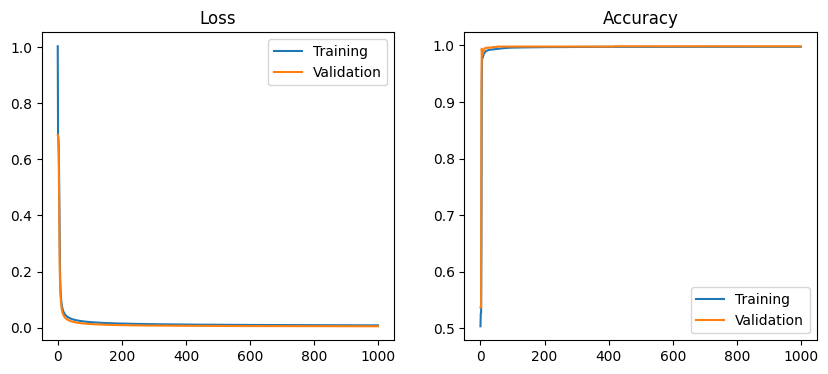

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(dense_history.history['loss'], label = 'Training')
ax1.plot(dense_history.history['val_loss'], label = 'Validation')

ax1.set_title('Loss')
ax1.legend()

ax2.plot(dense_history.history['accuracy'], label = 'Training')
ax2.plot(dense_history.history['val_accuracy'], label = 'Validation')

ax2.set_title('Accuracy')
ax2.legend()
plt.show()

# Save

In [13]:
# # Save
# np.save(f'output/data/classical/{dataset}/Loss{numHiddenNeurons}Hidden_{dataset}.npy',\
#         dense_history.history['loss'])
# np.save(f'output/data/classical/{dataset}/TestLoss{numHiddenNeurons}Hidden_{dataset}.npy',\
#         dense_history.history['val_loss'])
# np.save(f'output/data/classical/{dataset}/Accuracy{numHiddenNeurons}Hidden_{dataset}.npy',\
#         dense_history.history['accuracy'])
# np.save(f'output/data/classical/{dataset}/TestAccuracy{numHiddenNeurons}Hidden_{dataset}.npy',\
#         dense_history.history['val_accuracy'])